In [5]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../../../code/')

In [6]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Utils imports
import cohort_analysis_utils as utils

In [7]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

In [8]:
patient_data = pd.read_csv('data/patient_data.csv', index_col='Sample_Studies', header=0)
protein_data = pd.read_csv('data/protein_data.csv', index_col=[0,1], header=0)

# Log2 transformation to the data

According to my searches, DIA-Skyline intensity values are:

 - Right-skewed: Intensities span several orders of magnitude.
 - Heteroscedastic: High-intensity peptides show larger variance.
 - Non-normal: Violates logistic regression assumptions (even though it's more robust than linear regression).

Then, a log2 transformation of the data should make it more suitable to apply logistic regression and meet its assumptions.

In [5]:
protein_data_log2 = protein_data.applymap(lambda x: np.log2(x) if pd.notnull(x) and x > 0 else np.nan)

# Normalization of the data

Even with targeted methods like DIA:

- Sample injection volumes may vary slightly.
- LC-MS performance can drift over time (batch effects).
- Total ion current per run is not constant.

As a result, raw intensities for the same peptide may differ not due to biology, but due to technical effects, making sample-to-sample comparisons misleading.

Thus, sample-wise normalization should reduce technical bias, increase comparability of peptide profiles and improves model robustness.

In [6]:
protein_data_log2_norm = protein_data_log2.sub(protein_data_log2.median(axis=0), axis=1)

# Checking the skeweness of the data

If our log2 transformation has worked well, the data should be more normally distributed and not skewed, otherwise it is not meeting the logistic regression assumptions.

In [7]:
from scipy.stats import skew

skew_raw = protein_data.stack().skew()
skew_log2 = protein_data_log2.stack().skew()
skew_norm = protein_data_log2_norm.stack().skew()

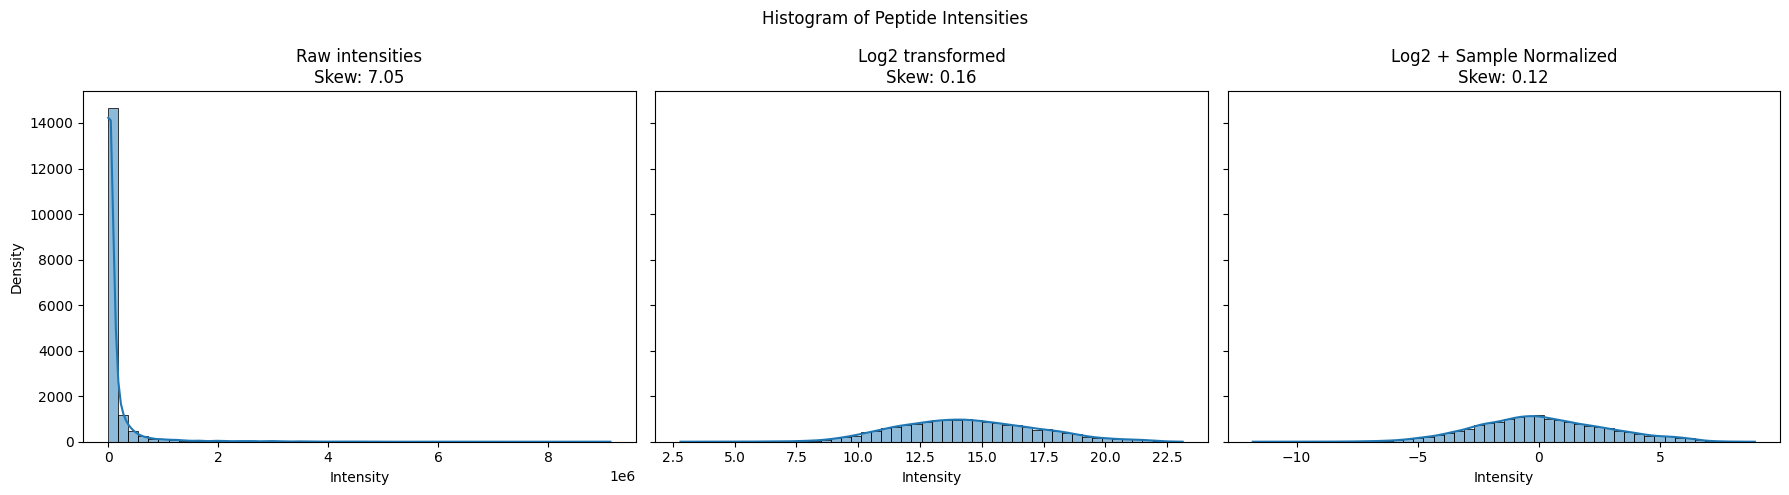

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
sns.histplot(protein_data.stack(), bins=50, ax=axs[0], kde=True)
axs[0].set_title(f"Raw intensities\nSkew: {skew_raw:.2f}")
sns.histplot(protein_data_log2.stack().dropna(), bins=50, ax=axs[1], kde=True)
axs[1].set_title(f"Log2 transformed\nSkew: {skew_log2:.2f}")
sns.histplot(protein_data_log2_norm.stack().dropna(), bins=50, ax=axs[2], kde=True)
axs[2].set_title(f"Log2 + Sample Normalized\nSkew: {skew_norm:.2f}")
for ax in axs: ax.set_xlabel("Intensity"); ax.set_ylabel("Density")
plt.suptitle("Histogram of Peptide Intensities")
plt.tight_layout()
plt.show()

# Checking the removal of the technical bias through normalization

Each point of the following PCA is a sample. PCA projects high-dimensional intensity profiles (many peptides) into 2D, the distance between the points approximates the similarity of samples' peptide expression profiles.


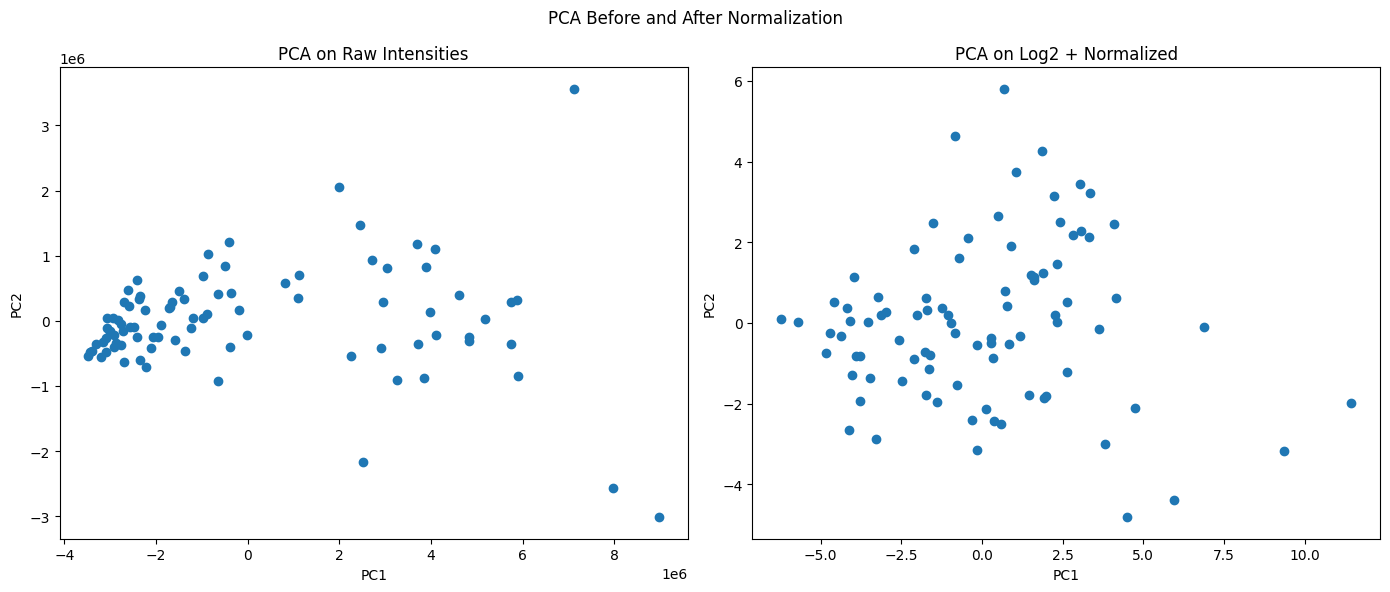

In [9]:
from sklearn.decomposition import PCA

pca_raw = PCA(n_components=2).fit_transform(protein_data.dropna().T)
pca_norm = PCA(n_components=2).fit_transform(protein_data_log2_norm.dropna().T)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].scatter(pca_raw[:, 0], pca_raw[:, 1])
axs[0].set_title("PCA on Raw Intensities")
axs[0].set_xlabel("PC1"); axs[0].set_ylabel("PC2")

axs[1].scatter(pca_norm[:, 0], pca_norm[:, 1])
axs[1].set_title("PCA on Log2 + Normalized")
axs[1].set_xlabel("PC1"); axs[1].set_ylabel("PC2")

plt.suptitle("PCA Before and After Normalization")
plt.tight_layout()
plt.show()

Before normalization we see set of closer points and points spreading around (in the PC1 axis mostly).

This typically suggests that:

- Some samples have much higher total intensity (high injection volume, LC bias, etc.).
- These dominate the first principal component (PC1), pulling points away.
- The tighter cluster are samples with similar total intensity, while the spread ones are outliers due to technical variation — not biology.

These variations may reflect technical artifacts, not underlying biology.

After log2 + median normalization the points are sparse, with no agglomeration.These suggests:

- The major technical bias (total intensity shift across samples) has been removed.
- The PCA space shows more balanced spread: samples now differ by subtler differences in peptide profiles rather than being dominated by signal strength.

This **suggests** that we have ve eliminated global shifts and can now analyze true signal.



# Model computing

Now, we can use the log2+normalized data in order to compute the logistic models.

In [10]:
# Some data cleaning

protein_data_log2_norm.index = [
    f"{gene}_{peptide}" for gene, peptide in protein_data_log2_norm.index
] # Concatenate gene and peptide names

protein_data_log2_norm = protein_data_log2_norm.T 

protein_data_log2_norm.index = [
    f"{sample.split("_")[0]}" for sample in protein_data_log2_norm.index
] # Take only the sample code from the index

In [11]:
BIOMARKERS = protein_data_log2_norm.columns.tolist()


In [12]:
# Merge the dataframes by index
full_data = patient_data.merge(
    protein_data_log2_norm,
    left_index=True,
    right_index=True,
    how='inner'
)

In [13]:
full_data = utils.cols_as_category(full_data, {'Condition':{'Benigna': 0, 'Hyp': 0, 'EC': 1}})
full_data.rename(columns={'Condition': 'Pathology'}, inplace=True)

In [14]:
full_data.Pathology.value_counts().to_frame().T

Pathology,1,0
count,48,36


We have set benign and hyperplasia samples as controls and EC samples as cancers. We have 48 cancers and 36 controls.

In [15]:
PLOT_ROCS = True
RESULTS_PATH = './results/'
METHODS = ['direct']

In [ ]:
for biomarker_count in [1]:
    print(f"Computing models with {biomarker_count} biomarkers")
    models = utils.compute_all_models_and_save(
                            df=full_data,
                            biomarkers=BIOMARKERS,
                            normalizing_col='', 
                            volume_col= '',
                            volume_added=0.0,
                            apply_log=False,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=biomarker_count,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            compute_auc_ci=False,
                            auc_threshold= 0.5,
                            )
    print(f"Models with {biomarker_count} biomarkers computed")

# Results summary

As a summary for the results, we're showing the classification performance for the peptides of the WomEC selected biomarkers. The full results table for individual biomarkers, along with the ROC curves plots and coordinates, can be found in the [results](./results/) folder within this analysis. 

Also, as a clarification, the Sensitivity and Specificity values show in the following tables are those maximizing the sum of both metrics. For a full detail of the ROC coordinates find the corresponding model within the results folder.

In [9]:
results = pd.read_csv("./results/direct/max_1.csv", index_col=0, header=0)

In [10]:
biomarkers = [
    biomarker for biomarker in results.index if biomarker.split('_')[0] in [
        "MVP", "PKM", "MMP9", "MPO", "TIMP2", "AGRN", "CLIC1"
    ]
]
# Filter the results dataframe to only include the selected biomarkers
results.loc[biomarkers][["AUC","Sensitivity","Specificity","NPV","PPV"]]

,AUC,Sensitivity,Specificity,NPV,PPV
Biomarker_1,,,,,
MVP_ELPPGVEELLNK,1.00000,1.00000,1.00000,1.00000,1.00000
PKM_APIIAVTR,0.82060,0.75000,0.86111,0.72093,0.87805
PKM_NTGIICTIGPASR,0.81771,0.66667,0.94444,0.68000,0.94118
CLIC1_LAALNPESNTAGLDIFAK,0.77267,0.67391,0.82857,0.65909,0.83784
AGRN_LELGIGPGAATR,0.69108,0.59091,0.77778,0.53846,0.81250
CLIC1_NSNPALNDNLEK,0.68981,0.83333,0.47222,0.68000,0.67797
MVP_LAQDPFPLYPGEVLEK,0.66034,0.78049,0.55556,0.62500,0.72727
MMP9_SLGPALLLLQK,0.60426,0.85106,0.50000,0.68182,0.72727
MPO_IANVFTNAFR,0.58775,0.22917,0.93939,0.45588,0.84615


As can be observed, MPV show perfect results for one of its peptides, but the other one has a poor performance. PKM (KPYM) peptides in the other hand show consistend results amongst them with an AUC around 0.82. 